# Use Case Load Grand Ensemble output fast

Challenge:
    - mm output in 1 file per year
    - concat over time, and member takes very long
    
Solution:
    - somehow speedup concat over time and member
    - postprocess (optional with cdo) and save in one file, then load this one

# Solution: postprocess and save in one file

In [2]:
#PMMPIESM implementation

# Solution: speedup concat

In [3]:
# decode_times=False, decode_cf=False

In [1]:
import xarray as xr
import PMMPIESM as PM
import pandas as pd

In [2]:
from PMMPIESM.setup import _squeeze_dims, yearmonmean

In [3]:
def v(ds):
    return ds['sst'].squeeze().to_dataset(name='sst')

In [4]:
PM.setup.GE_path

'/work/mh0727/m300524/experiments/GE/'

In [5]:
def GE_files(exp='hist',id=1,model='mpiom',outdatatype='data_2d_mm',timestr='18[5-7]*'):
    run_id = exp+str(id).zfill(4)
    path='/'.join(('/work','mh0727','m300524','experiments','GE',exp,run_id,'outdata',model))
    nc_files = path+ '/' + '_'.join((run_id,model,outdatatype,timestr))
    return nc_files

In [5]:
GE_files(id='0*')

'/work/mh0727/m300524/experiments/GE/hist/hist000*/outdata/mpiom/hist000*_mpiom_data_2d_mm_18[5-7]*'

In [16]:
#%time ds = xr.open_mfdataset(GE_files())

In [ ]:
%time ds = xr.open_mfdataset(GE_files(),parallel=True)

## with dask client

In [6]:
from dask.distributed import Client
client = Client(processes=False, threads_per_worker=6, n_workers=8, memory_limit='16GB')
client

Client Scheduler: inproc://10.50.47.254/43479/1 Dashboard: http://localhost:8888/proxy/8787/status,Cluster Workers: 8 Cores: 48 Memory: 128.00 GB


## SLURM

In [6]:
from dask_jobqueue import SLURMCluster
from dask.distributed import Client
cluster = SLURMCluster(processes=8, cores=24, memory="16GB")

In [7]:
cluster.scale(16)

In [8]:
cluster.job_script()

'#!/bin/bash\n\n#!/usr/bin/env bash\n#SBATCH -J dask-worker\n#SBATCH -p compute2\n#SBATCH -A mh0727\n#SBATCH -n 1\n#SBATCH --cpus-per-task=24\n#SBATCH --mem=15G\n#SBATCH -t 00:30:00\nJOB_ID=${SLURM_JOB_ID%;*}\n\n\n\n/work/mh0727/m300524/anaconda3/envs/my_jupyter/bin/python -m distributed.cli.dask_worker tcp://10.50.47.254:39416 --nthreads 3 --nprocs 8 --memory-limit 2.00GB --name dask-worker--${JOB_ID}-- --death-timeout 60 --local-directory /scratch/m/m300524/dask --interface ib0\n'

In [9]:
client = Client(cluster)
#cluster.adapt()

In [10]:
client

Client Scheduler: tcp://10.50.47.254:39416 Dashboard: http://localhost:8888/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


## load

In [14]:
%time ds = xr.open_mfdataset(GE_files(timestr='*'),parallel=False,preprocess=v,decode_times=True,concat_dim='time')#.compute()

CPU times: user 16.3 s, sys: 2.58 s, total: 18.9 s
Wall time: 20.5 s


In [15]:
%time ds = xr.open_mfdataset(GE_files(timestr='*'),parallel=True,preprocess=v,decode_times=True,concat_dim='time')#.compute()

CPU times: user 30 s, sys: 8.77 s, total: 38.8 s
Wall time: 32.1 s


In [16]:
ds

<xarray.Dataset>
Dimensions:  (time: 1872, x: 256, y: 220)
Coordinates:
    lon      (y, x) float64 -47.25 -47.69 -48.12 -48.54 ... 131.3 132.5 133.8
    lat      (y, x) float64 76.36 76.3 76.24 76.17 ... -77.25 -77.39 -77.54
    depth    float64 0.0
  * time     (time) datetime64[ns] 1850-01-31T23:15:00 ... 2005-12-31T23:15:00
Dimensions without coordinates: x, y
Data variables:
    sst      (time, y, x) float32 dask.array<shape=(1872, 220, 256), chunksize=(12, 220, 256)>

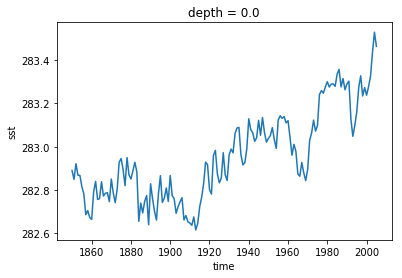

In [17]:
yearmonmean(ds.mean(['x','y']))['sst'].plot()

## Load from one file

In [11]:
path='/work/mh1007/MPI-GE_processed/hist/hist_1850-2005_ens_1-100.tsurf.nc'

In [12]:
ds=xr.open_mfdataset(path,decode_times=False,parallel=True,chunks=({'time':'12'}))

In [13]:
ds.nbytes/1e9

13.801897728

In [14]:
ds

<xarray.Dataset>
Dimensions:  (ens: 100, lat: 96, lon: 192, time: 1872)
Coordinates:
  * time     (time) float64 1.85e+07 1.85e+07 1.85e+07 ... 2.005e+07 2.005e+07
  * lon      (lon) float32 0.0 1.875 3.75 5.625 ... 352.5 354.375 356.25 358.125
  * lat      (lat) float32 88.57217 86.722534 84.86197 ... -86.722534 -88.57217
Dimensions without coordinates: ens
Data variables:
    tsurf    (time, ens, lat, lon) float32 dask.array<shape=(1872, 100, 96, 192), chunksize=(1, 100, 96, 192)>
Attributes:
    CDI:                       Climate Data Interface version 1.9.2 (http://m...
    Conventions:               CF-1.6
    history:                   Fri Mar 09 13:04:40 2018: cdo splitname /work/...
    source:                    ECHAM6
    institution:               Max-Planck-Institute for Meteorology
    NCO:                       4.6.7
    nco_openmp_thread_number:  1
    CDO:                       Climate Data Operators version 1.9.2 (http://m...

In [15]:
%time
gm = ds.mean(['lon','lat']).compute()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 11.4 µs


In [16]:
span = pd.date_range(start='1/1/1850', periods=ds.time.size, freq='M')
gm['time']=span

In [17]:
GMST=yearmonmean(gm)

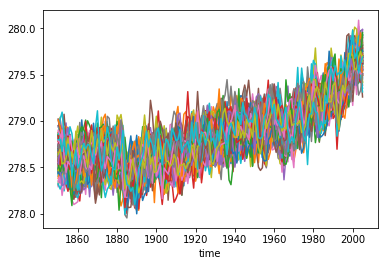

In [18]:
GMST.to_dataframe().unstack(0).plot(legend=False)

In [33]:
%time ds = xr.open_mfdataset(GE_files(),parallel=True,decode_times=False,concat_dim='time')

CPU times: user 11.4 s, sys: 1.53 s, total: 12.9 s
Wall time: 12.7 s


In [34]:
#looses fill value info
%time ds = xr.open_mfdataset(GE_files(),parallel=True,decode_cf=False,concat_dim='time')

CPU times: user 4.32 s, sys: 1.14 s, total: 5.46 s
Wall time: 4.01 s


In [20]:
str(ds.nbytes/1e9)+' GB'

'4.784950104 GB'

/work/mh0727/m300524/anaconda3/envs/my_jupyter/lib/python3.6/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


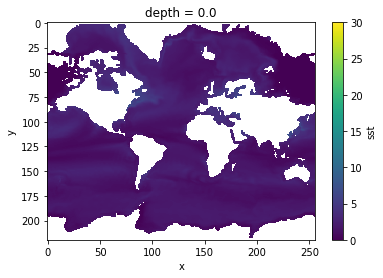

In [35]:
(ds['sst']-273.15).squeeze().std('time').plot(vmin=0,vmax=30,yincrease=False)

## xr.auto_combine

In [36]:
# dont underestand this
# http://xarray.pydata.org/en/stable/generated/xarray.auto_combine.html?highlight=auto_combine
l=[]
for id in range(5):
    l.append(xr.open_mfdataset(GE_files(id=id))
ds=xr.auto_combine(l)

SyntaxError: invalid syntax (<ipython-input-36-98ec6f49c8b9>, line 6)

In [37]:
#https://gist.github.com/jnhansen/fa474a536201561653f60ea33045f4e2
import glob
import xarray as xr
import itertools
import numpy as np

def auto_merge(datasets):
    """
    Automatically merge a split xarray Dataset. This is designed to behave like
    `xarray.open_mfdataset`, except it supports concatenation along multiple
    dimensions.
    Parameters
    ----------
    datasets : str or list of str or list of xarray.Dataset
        Either a glob expression or list of paths as you would pass to
        xarray.open_mfdataset, or a list of xarray datasets. If a list of
        datasets is passed, you should make sure that they are represented
        as dask arrays to avoid reading the whole dataset into memory.
    Returns
    -------
    xarray.Dataset
        The merged dataset.
    """
    # Treat `datasets` as a glob expression
    if isinstance(datasets, str):
        datasets = glob.glob(datasets)

    # Treat `datasets` as a list of file paths
    if isinstance(datasets[0], str):
        # Pass chunks={} to ensure the dataset is read as a dask array
        datasets = [xr.open_dataset(path, chunks={}) for path in datasets]

    def _combine_along_last_dim(datasets):
        merged = []

        # Determine the dimension along which the dataset is split
        split_dims = [d for d in datasets[0].dims if
                      len(np.unique([ds[d].values[0] for ds in datasets])) > 1]

        # Concatenate along one of the split dimensions
        concat_dim = split_dims[-1]

        # Group along the remaining dimensions and concatenate within each
        # group.
        sorted_ds = sorted(datasets, key=lambda ds: tuple(ds[d].values[0]
                                                          for d in split_dims))
        for _, group in itertools.groupby(
                sorted_ds,
                key=lambda ds: tuple(ds[d].values[0] for d in split_dims[:-1])
                ):
            merged.append(xr.auto_combine(group, concat_dim=concat_dim))

        return merged

    merged = datasets
    while len(merged) > 1:
        merged = _combine_along_last_dim(merged)

    return merged[0]

In [38]:
%time ds = auto_merge(GE_files())

CPU times: user 8.22 s, sys: 529 ms, total: 8.75 s
Wall time: 9.87 s


In [24]:
ds = auto_merge([sorted(glob.glob(GE_files(id=id))) for id in range(1,4)])

AttributeError: 'list' object has no attribute 'dims'